In [ ]:
#Greenhouse plant project

In [ ]:
import kagglehub
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.matlib import repmat
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Set the path to the file you'd like to load
file_path = "Greenhouse Plant Growth Metrics.csv"

# List files in the dataset to find the correct file name
# print("Listing files in the dataset directory:")
# !ls /kaggle/input/greenhouse-plant-growth-metrics/
# print("-" * 30)
# print("Please update the 'file_path' variable with the correct file name from the list above.")

# Load the latest version
# Temporarily commenting out to prevent immediate error after listing files.
# Please uncomment and run after updating file_path.
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "adilshamim8/greenhouse-plant-growth-metrics",
  file_path,
)

# Next steps for data exploration
print("--- First 5 Rows of the DataFrame ---")
print(df.head())

print("\n--- DataFrame Information (Columns, Dtypes, Missing Values) ---")
df.info()

/tmp/ipython-input-226480650.py:28: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 6.50M/6.50M [00:00<00:00, 21.3MB/s]


--- First 5 Rows of the DataFrame ---
  Random       ACHP        PHR     AWWGV         ALAP      ANPL        ARD  \
0     R1  34.533468  54.566983  1.147449  1284.229549  4.999713  16.274918   
1     R1  34.489028  54.567692  1.149530  1284.247744  5.024259  16.269452   
2     R2  33.100405  67.067344  1.104647  1009.208996  5.007652  15.980760   
3     R1  34.498319  54.559049  1.137759  1284.227623  4.991501  16.276710   
4     R3  36.297008  45.588894  1.363205   981.470310  4.003682  16.979894   

       ADWR      PDMVG        ARL      AWWR      ADWV      PDMRG Class  
0  1.706810  18.399982  19.739037  2.949240  0.209251  57.633906    SA  
1  1.700930  18.398289  19.758836  2.943137  0.216154  57.633697    SA  
2  1.185391  19.398789  20.840822  2.861635  0.200113  41.289875    SA  
3  1.716396  18.413613  19.736098  2.946784  0.223092  57.645661    SA  
4  0.777428  31.423772  17.331894  2.766242  0.424172  27.898619    SA  

--- DataFrame Information (Columns, Dtypes, Missing Va

In [ ]:
# --- 1.1 Feature Definition and Target Creation ---

# Define the 12 numerical input features (X)
feature_cols = ['ACHP', 'PHR', 'AWWGV', 'ALAP', 'ANPL', 'ARD', 'ADWR', 'PDMVG', 'ARL', 'AWWR', 'ADWV', 'PDMRG']
X = df[feature_cols].copy()

# Create the binary Target Variable (Y)
# 'S' classes -> 1 (IoT-Enabled), 'T' classes -> 0 (Traditional)
df['Target'] = df['Class'].apply(lambda x: 1 if x.startswith('S') else 0)
Y = df['Target']

print("\n--- Target Variable Check ---")
print(f"Shape of Input Features (X): {X.shape}")
print(f"Target Distribution:\n{Y.value_counts()}")


--- Target Variable Check ---
Shape of Input Features (X): (30000, 12)
Target Distribution:
Target
1    15000
0    15000
Name: count, dtype: int64


In [ ]:
# --- 1.2 Data Splitting (60% Train, 20% Validation, 20% Test) ---

# 1. First Split: Separate 20% for the Test set, leaving 80% for Train+Validation
# Use stratify to maintain class balance
X_train_val, X_test, Y_train_val, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

# 2. Second Split: Split the remaining 80% into Train (60% of total) and Validation (20% of total)
# 0.25 = 20% / 80%
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_val, Y_train_val, test_size=0.25, random_state=42, stratify=Y_train_val
)

print("\n--- 1.2 Data Split Verification ---")
print(f"Training Set size: {len(X_train)} ({len(X_train)/len(X)*100:.0f}%)")
print(f"Validation Set size: {len(X_val)} ({len(X_val)/len(X)*100:.0f}%)")
print(f"Testing Set size: {len(X_test)} ({len(X_test)/len(X)*100:.0f}%)")


--- 1.2 Data Split Verification ---
Training Set size: 18000 (60%)
Validation Set size: 6000 (20%)
Testing Set size: 6000 (20%)


In [ ]:
# --- 1.3 Standardization (Z-score Normalization) ---

# Initialize the StandardScaler
scaler = StandardScaler()

# 1. Fit the scaler ONLY on the Training Data to prevent data leakage.
# The mean and std dev are calculated only from X_train.
scaler.fit(X_train)

# 2. Apply the fitted transformation to all three sets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n--- 1.3 Standardization Complete ---")
# Check standardization on the training set (should be close to 0 and 1)
print(f"X_train_scaled Mean Check: {X_train_scaled.mean(axis=0).round(2)}")
print(f"X_train_scaled Std Dev Check: {X_train_scaled.std(axis=0).round(2)}")


--- 1.3 Standardization Complete ---
X_train_scaled Mean Check: [-0. -0. -0. -0.  0. -0. -0. -0. -0.  0. -0.  0.]
X_train_scaled Std Dev Check: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# ---------------------------------------
# Utility function for evaluation
# ---------------------------------------
def evaluate_model(model, X_test, Y_test):
    preds = model.predict(X_test)
    acc = accuracy_score(Y_test, preds)
    prec = precision_score(Y_test, preds)
    rec = recall_score(Y_test, preds)
    f1 = f1_score(Y_test, preds)

    return {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "Preds": preds
    }


In [ ]:
# ---------------------------------------
# 2.1 Baseline Model: Logistic Regression
# ---------------------------------------
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_scaled, Y_train)

print("\n--- Logistic Regression Validation Results ---")
print(evaluate_model(log_reg, X_val_scaled, Y_val))


--- Logistic Regression Validation Results ---
{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Preds': array([1, 0, 1, ..., 0, 1, 1])}


In [ ]:
# ---------------------------------------
# 2.1 Primary Model 1: Support Vector Machine (SVM)
# ---------------------------------------
svm = SVC(kernel='rbf', C=1.0, gamma='scale')
svm.fit(X_train_scaled, Y_train)

print("\n--- SVM Validation Results ---")
print(evaluate_model(svm, X_val_scaled, Y_val))


--- SVM Validation Results ---
{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Preds': array([1, 0, 1, ..., 0, 1, 1])}


In [ ]:
# ---------------------------------------
# 2.1 Primary Model 2: K-Nearest Neighbors (kNN)
# ---------------------------------------
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, Y_train)

print("\n--- kNN Validation Results ---")
print(evaluate_model(knn, X_val_scaled, Y_val))


--- kNN Validation Results ---
{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Preds': array([1, 0, 1, ..., 0, 1, 1])}


In [ ]:
print("\n=== TEST SET PERFORMANCE ===")
print("Logistic Regression:", evaluate_model(log_reg, X_test_scaled, Y_test))
print("SVM:", evaluate_model(svm, X_test_scaled, Y_test))
print("kNN:", evaluate_model(knn, X_test_scaled, Y_test))


=== TEST SET PERFORMANCE ===
Logistic Regression: {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Preds': array([0, 1, 0, ..., 0, 1, 0])}
SVM: {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Preds': array([0, 1, 0, ..., 0, 1, 0])}
kNN: {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Preds': array([0, 1, 0, ..., 0, 1, 0])}


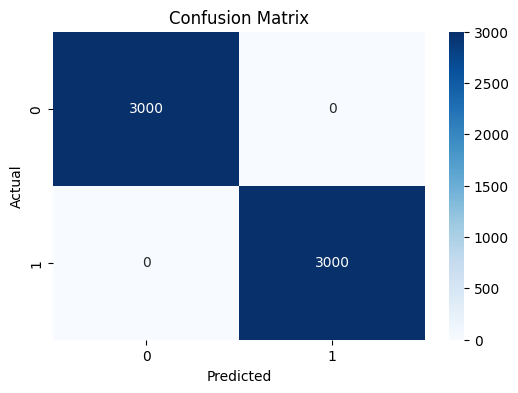

In [ ]:
best_model = svm  # change this if needed
best_preds = best_model.predict(X_test_scaled)

cm = confusion_matrix(Y_test, best_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
probe = LogisticRegression(C=1e12, max_iter=500)
probe.fit(X_train_scaled, Y_train)
print("Probe accuracy:", accuracy_score(Y_test, probe.predict(X_test_scaled)))


Probe accuracy: 1.0
